In [21]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
#tf.get_logger().setLevel('ERROR') # turn off tf warnings 
import tensorflow as tf
import glob
import warnings
warnings.filterwarnings("ignore")

# EDA

In [22]:
train = pd.read_csv('train.csv')

In [23]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [24]:
train.shape

(990, 194)

In [25]:
# Number of unique values 
train.nunique(axis=0) 

id           990
species       99
margin1       46
margin2       85
margin3       66
            ... 
texture60    102
texture61     53
texture62    127
texture63     65
texture64     97
Length: 194, dtype: int64

In [26]:
# Missing value percentage
train.apply(lambda x: x.isnull().sum() / x.isnull().count()*100)

id           0.0
species      0.0
margin1      0.0
margin2      0.0
margin3      0.0
            ... 
texture60    0.0
texture61    0.0
texture62    0.0
texture63    0.0
texture64    0.0
Length: 194, dtype: float64

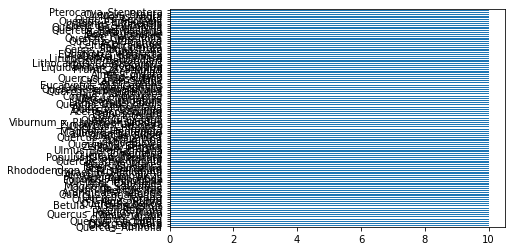

In [28]:
train['species'].value_counts().plot(kind = 'barh')
plt.show()

#### balanced class

In [29]:
train2 = train.drop(['shape33', 'species'], axis = 1)

In [30]:
# Check Collinearity

def get_redundant_pairs(train):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = train.columns
    for i in range(0, train.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(train, n=5):
    au_corr = train.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(train)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train2, 190))

Top Absolute Correlations
shape49  shape50    0.993873
shape17  shape18    0.993863
shape15  shape16    0.993723
shape16  shape17    0.993606
shape18  shape19    0.993604
                      ...   
shape50  shape53    0.951997
shape19  shape49    0.951760
shape14  shape49    0.951027
shape10  shape13    0.950881
shape11  shape45    0.950586
Length: 190, dtype: float64


#### High collinearity

In [68]:
# Check Coefficient of Variation

result = pd.DataFrame()
for thisVar in train2.iloc[:,1:190].columns:
    minimum = min(train2[thisVar])
    maximum = max(train2[thisVar])
    mean = np.mean(train2[thisVar])
    std = np.std(train2[thisVar], ddof = 1)
    coefVar = std / max(1.0, abs(mean))
    if mean < 0:
        coefVar = -coefVar
  
    result = result.append([[thisVar, minimum, maximum, mean, std, \
                            coefVar]],ignore_index = True)

result = result.rename(columns= {0:'Feature Field', 1: 'minimum', 
                                 2: 'maximum', 3: 'mean',
                                 4: 'std', 5 :'Coefficient of Variation'})
result
result.sort_values(by='Coefficient of Variation')

,Feature Field,minimum,maximum,mean,std,Coefficient of Variation
100,shape38,0.000064,0.002107,0.000621,0.000240,0.000240
99,shape37,0.000067,0.002011,0.000642,0.000242,0.000242
101,shape39,0.000062,0.002106,0.000602,0.000245,0.000245
121,shape59,0.000063,0.001740,0.000607,0.000245,0.000245
91,shape28,0.000087,0.001810,0.000644,0.000245,0.000245
...,...,...,...,...,...,...
159,texture33,0.000000,0.430660,0.023243,0.058630,0.058630
186,texture60,0.000000,0.578130,0.014017,0.060151,0.060151
181,texture55,0.000000,0.429690,0.036501,0.063403,0.063403
141,texture15,0.000000,0.853520,0.012030,0.063881,0.063881


In [32]:
test = pd.read_csv('test.csv')

In [33]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [34]:
Y_id = train.pop('id')

Y_label = train.pop('species')

test_id = test.pop('id')

X = train.values

X_test = test.values

In [35]:
# Standardize data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_testS = scaler.transform(X_test)

In [36]:
# split training set to training and validation

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(random_state=233, test_size=0.2)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_label = pd.Series(encoder.fit_transform(Y_label))

#x_train, x_valid, y_train, y_valid
train_ID, valid_ID = next(sss.split(X_scaled, y_label))

In [37]:
X_train, y_train = X_scaled[train_ID], y_label[train_ID]

X_valid, y_valid = X_scaled[valid_ID], y_label[valid_ID]

In [38]:
train_id = Y_train_id.loc[y_train.index]
train_species = Y_train.loc[y_train.index]

valid_id = Y_train_id.loc[y_valid.index]
valid_species = Y_train.loc[y_valid.index] 

# Modeling

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf1 = RandomForestClassifier(random_state=233, n_jobs=-1)
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_valid)
confusion_matrix = confusion_matrix(y_valid, pred1)

print(classification_report(y_true=y_valid, y_pred=pred1))
print(confusion_matrix)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(clf1.score(X_valid, y_valid)*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

## LDA

In [50]:
# testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train,y_train)
y_pred = model_lda.predict(X_valid)

confusion_matrix = confusion_matrix(y_valid, y_pred)

print(classification_report(y_valid, y_pred))
print(confusion_matrix)
print('Accuracy of LDA classifier on testing set: {:.2f}'.format(model_lda.score(X_valid, y_valid)*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

In [54]:
# training
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda2 = LinearDiscriminantAnalysis()
model_lda2.fit(X_train,y_train)
y_pred2 = model_lda2.predict(X_train)

confusion_matrix = confusion_matrix(y_valid, y_pred)

print(classification_report(y_valid, y_pred))
print(confusion_matrix)
print('Accuracy of LDA classifier on training set: {:.2f}'.format(model_lda2.score(X_train, y_train)*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

## QDA

In [65]:
# testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_qda = QuadraticDiscriminantAnalysis()
model_qda.fit(X_train,y_train)
y_pred = model_qda.predict(X_valid)

confusion_matrix = confusion_matrix(y_valid, y_pred)

print(classification_report(y_valid, y_pred))
print(confusion_matrix)
print('Accuracy of QDA classifier on testing set: {:.2f}'.format(model_qda.score(X_valid, y_valid)*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00    

In [66]:
# training
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_qda2 = QuadraticDiscriminantAnalysis()
model_qda2.fit(X_train,y_train)
y_pred2 = model_qda2.predict(X_train)

confusion_matrix2 = confusion_matrix(y_train, y_pred2)

print(classification_report(y_train, y_pred2))
print(confusion_matrix)
print('Accuracy of QDA classifier on training set: {:.2f}'.format(model_qda2.score(X_train, y_train)*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00    

## SVM

In [63]:
# testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn import svm

model_svm = svm.SVC(gamma=0.001, C=100.)
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_valid)

rmse = mean_squared_error(y_valid, y_pred, squared=False)
confusion_matrix = confusion_matrix(y_valid, y_pred)

print(classification_report(y_valid, y_pred))
print(confusion_matrix)
print('Accuracy of SVM classifier on testing set: {:.2f}'.format(model_svm.score(X_valid, y_valid)*100))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

In [64]:
#svm training
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn import svm

model_svm2 = svm.SVC(gamma=0.001, C=100.)
model_svm2.fit(X_train,y_train)
y_pred2 = model_svm2.predict(X_train)

rmse = mean_squared_error(y_train, y_pred2, squared=False)
confusion_matrix2 = confusion_matrix(y_train, y_pred2)

print(classification_report(y_train, y_pred2))
print('Accuracy of SVM classifier on training set: {:.2f}'.format(model_svm2.score(X_train, y_train)*100))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00    

# image preparation

In [12]:
import shutil
#create folder
original_path = 'images'

new_path = 'splited_images'

os.mkdir(new_path) # create this folder

train_dir = os.path.join(new_path,'train')
valid_dir = os.path.join(new_path, 'validation')


os.mkdir(train_dir)
os.mkdir(valid_dir)

def create_species_folder(path):
    for specie in Y_train.unique():
        specie_path = os.path.join(path, specie)
        os.mkdir(specie_path)

create_species_folder(train_dir)
create_species_folder(valid_dir)

def copy_image(idx, species, path):
    for i in idx.index:
        name = '{}.jpg'.format(idx.loc[i])
        specie = species.loc[i]
        specie_path = os.path.join(path, specie)
        src = os.path.join(original_path, name)
        dst = os.path.join(specie_path, name)
        shutil.copyfile(src, dst)

copy_image(train_id, train_species, train_dir)
copy_image(valid_id, valid_species, valid_dir)



In [13]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                       shear_range = 0.5,
                                                       horizontal_flip = True)

In [14]:
target_size = (96, 96)
batch_size = 32
class_mode = 'categorical'

In [15]:
training_set = datagen.flow_from_directory(directory= train_dir, 
                                           target_size= target_size, 
                                           batch_size= batch_size, 
                                           class_mode= class_mode)

Found 792 images belonging to 99 classes.


In [16]:
valid_set = datagen.flow_from_directory(directory= valid_dir, 
                                        target_size= target_size, 
                                        batch_size= batch_size, 
                                        class_mode= class_mode)

Found 198 images belonging to 99 classes.


cnn example

In [17]:
#create a model
def classifier():
    model = keras.Sequential([
        keras.layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (96,96,3), activation = "relu" ),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(units = 128, activation = 'relu'),
        keras.layers.Dense(units = 99, activation = 'softmax')
    ])
    return model

In [18]:
clf2 = classifier()

In [19]:
clf2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [20]:
history = clf2.fit(training_set, validation_data=valid_set, epochs=10, batch_size=batch_size)

Epoch 1/10
25/25 [==============================] - 8s 239ms/step - loss: 4.6446 - accuracy: 0.0376 - val_loss: 4.3052 - val_accuracy: 0.0657
Epoch 2/10
25/25 [==============================] - 4s 171ms/step - loss: 3.7215 - accuracy: 0.1771 - val_loss: 3.2630 - val_accuracy: 0.2677
Epoch 3/10
25/25 [==============================] - 4s 170ms/step - loss: 2.4407 - accuracy: 0.4144 - val_loss: 2.5148 - val_accuracy: 0.3838
Epoch 4/10
25/25 [==============================] - 4s 166ms/step - loss: 1.3768 - accuracy: 0.6439 - val_loss: 2.1998 - val_accuracy: 0.4242
Epoch 5/10
25/25 [==============================] - 4s 160ms/step - loss: 1.0737 - accuracy: 0.7220 - val_loss: 2.2615 - val_accuracy: 0.4545
Epoch 6/10
25/25 [==============================] - 4s 178ms/step - loss: 0.8560 - accuracy: 0.7427 - val_loss: 2.1768 - val_accuracy: 0.4747
Epoch 7/10
25/25 [==============================] - 4s 164ms/step - loss: 0.4651 - accuracy: 0.8624 - val_loss: 2.1095 - val_accuracy: 0.5303
Epoch 

In [29]:
print('accuracy is ', round(clf2.evaluate(valid_set, verbose =0)[1], 4))

accuracy is  0.5101


In [22]:
def test_img(model):
    test_df = pd.DataFrame(columns= Y_train.unique())
    for i in test_id:
        name = '{}.jpg'.format(i)
        test_path = os.path.join(original_path, name) 
        img = keras.preprocessing.image.load_img(test_path, target_size = target_size)
        img = keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        res = model.predict(img)
        test_df.loc[i] = res[0]
    
    return test_df

In [23]:
submission = test_img(clf2)

In [24]:
submission.head()

,Acer_Opalus,Pterocarya_Stenoptera,Quercus_Hartwissiana,Tilia_Tomentosa,Quercus_Variabilis,Magnolia_Salicifolia,Quercus_Canariensis,Quercus_Rubra,Quercus_Brantii,Salix_Fragilis,...,Quercus_Ellipsoidalis,Quercus_x_Hispanica,Quercus_Shumardii,Quercus_Rhysophylla,Castanea_Sativa,Ulmus_Bergmanniana,Quercus_Nigra,Salix_Intergra,Quercus_Infectoria_sub,Sorbus_Aria
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
submission.apply(sum,axis=1)

4       1.0
7       1.0
9       1.0
12      1.0
13      1.0
       ... 
1576    1.0
1577    1.0
1579    1.0
1580    1.0
1583    1.0
Length: 594, dtype: float64